In [1]:
from tqdm import tqdm
from array_lib import *
from point3d_lib import Point
from skeleton3d_lib import Skeleton

from skimage.morphology import skeletonize
from ply_creation_lib import create_ply, create_ply_normals
import matplotlib.pyplot as plt
import pydicom as dicom
import numpy as np
import pickle
import time
import copy
import os

KeyboardInterrupt: 

In [3]:
"""
input_folder - must contain dcm files directly within it and only of one scan.
offsets - range of colors to include
seed - the entry coordinate to the aorta, must be the center.
threshold - normalized image color lower threshold
image_center - point between the arteries of interest
"""

# input_folder = f'{os.getcwd()}\\20241209_46'
# offsets = (-30, 20)
# seed = (20, 275, 160)
# hounsfield_thresh = 250
# image_center = (150, 280, 230)
# min_skeleton_length = 100

# input_folder = f'{os.getcwd()}\\20241209_17'
# offsets = (-20, 20)
# seed = (20, 258, 117)
# hounsfield_thresh = 250
# image_center = (150, 280, 230)
# min_skeleton_length = 100





input_folder = f'{os.getcwd()}\\20240923_84'
offsets = (-15, 20)
seed = (20, 310, 160)
# hounsfield_thresh = 250
# the middle of the filtered heart contour when selecting skeletons
# the line between the seed and the center of a filtered heart contour when looking for head
image_center = (150, 280, 230)
min_skeleton_length = 100

In [4]:
def read_dicom(input_folder: str) -> np.ndarray:
    files: list[str] = os.listdir(input_folder)
    data = [dicom.dcmread(f'{input_folder}\\{file}') for file in files if file.endswith('.dcm')]
    image = np.array([dicom.pixel_array(datum) for datum in data])
    return image

def clip_image_colors(image: np.ndarray, hounsfield_threshold: int) -> np.ndarray:
    image = copy.deepcopy(image)
    
    image = np.where((image > hounsfield_threshold) | (image < 2000), image, 0)
    min_val = 0
    max_val = 2000
    image = (image - min_val) / (max_val - min_val) * 200
    image = np.where(image > 0, image + 55, 0)
    return image

def normalize_image_colors(image: np.ndarray) -> np.ndarray:
    image = copy.deepcopy(image)
    min_val = np.min(image)
    max_val = np.max(image)
    image = (image - min_val) / (max_val - min_val) * 255
    return image

base_image = read_dicom(input_folder)
# image = clip_image_colors(base_image, hounsfield_thresh)
image = normalize_image_colors(base_image)

In [5]:
filtered_mask = custom_floodfill_3d(image, seed_point=seed, new_value=-1, offsets=offsets)
eroded_mask = erode_3d(filtered_mask)

In [6]:
heartless_mask = remove_heart(eroded_mask)

	--eroding: 1.284s
	--dilating: 4.235s


In [7]:
trimmed_mask = distinguish_3d(heartless_mask)

	--labeling: 1.113s
231 features
	--dividing blobs: 23.181s


In [8]:
skeleton_mask = skeletonize(trimmed_mask)
closest_skeletons = find_closest_skeletons(skeleton_mask, image_center)
skeleton_points = np.concatenate([i[0] for i in closest_skeletons])
filtered_skeleton_mask = np.zeros_like(skeleton_mask).astype(bool)
filtered_skeleton_mask[skeleton_points[:, 0], skeleton_points[:, 1], skeleton_points[:, 2]] = True

selected_skeletons = floodfill_nearby_skeletons(heartless_mask, closest_skeletons)

	--labeling: 1.111s
	--dividing blobs: 1.433s


In [9]:
chosen_skeletons = [s[0] for s in closest_skeletons][:2]
center_point = Point(image_center)

skeletons: list[Skeleton] = []
for chosen_skeleton in chosen_skeletons:    
    skeleton = Skeleton()
    skeleton.create(chosen_skeleton, filtered_skeleton_mask, center_point)
    skeletons.append(skeleton)

In [10]:
branches: list[Skeleton] = []
for skeleton in skeletons:
    these_branches = skeleton.split_into_branches(min_skeleton_length)
    branches.extend(these_branches)

In [11]:
branches[0].name = 'RCA'
branches[1].name = 'LAD'
branches[2].name = 'LCX'
for i, branch in enumerate(branches):
    branch.calculate_normals()
    # create_ply_normals(branch, f'normals_{branch.name}.ply')

In [12]:
#exporting the skeleton
output_skel = []
for i in branches[1].points:
    output_skel.append(str(tuple(i.coordinates)))
print(f'[{', '.join(output_skel)}]')

[(123, 325, 234), (124, 326, 234), (125, 327, 234), (125, 328, 235), (126, 329, 235), (126, 330, 235), (127, 331, 235), (127, 332, 235), (128, 333, 235), (128, 334, 235), (129, 335, 235), (128, 336, 236), (127, 337, 237), (127, 338, 238), (126, 338, 239), (125, 338, 240), (125, 339, 241), (125, 339, 242), (124, 340, 243), (123, 340, 244), (122, 341, 245), (122, 341, 246), (122, 341, 247), (122, 341, 248), (121, 341, 249), (120, 341, 250), (120, 341, 251), (120, 342, 252), (120, 341, 253), (119, 341, 254), (119, 341, 255), (119, 341, 256), (119, 341, 257), (119, 341, 258), (118, 341, 259), (117, 342, 260), (117, 341, 261), (116, 341, 262), (116, 341, 263), (117, 341, 264), (116, 341, 265), (115, 340, 265), (114, 340, 266), (113, 340, 266), (112, 339, 267), (111, 339, 268), (111, 339, 269), (111, 338, 270), (110, 338, 271), (109, 337, 272), (109, 337, 273), (108, 336, 274), (108, 336, 275), (107, 335, 276), (107, 334, 277), (107, 334, 278), (106, 333, 279), (107, 332, 280), (107, 331, 28

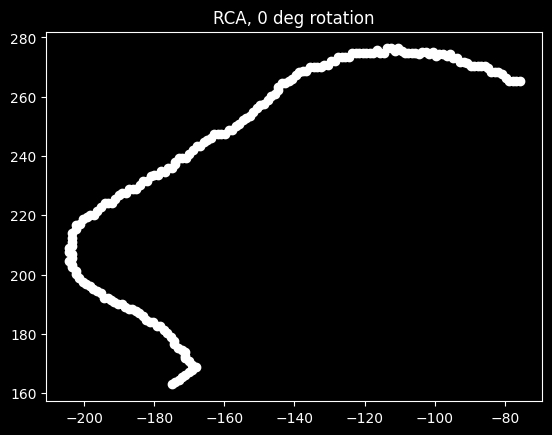

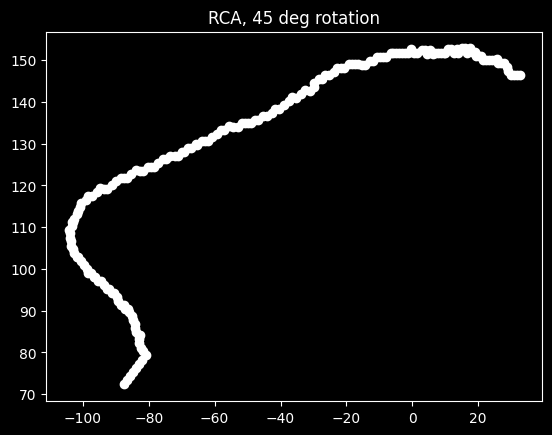

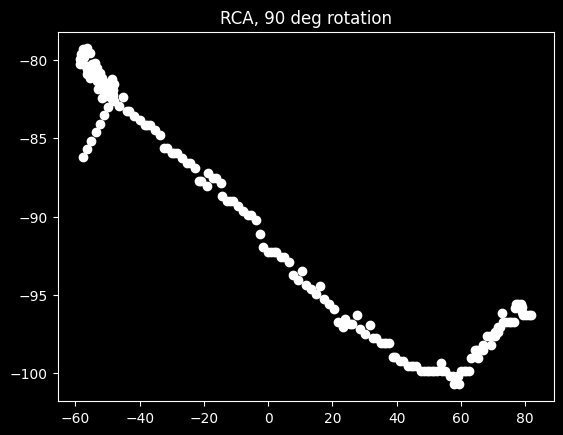

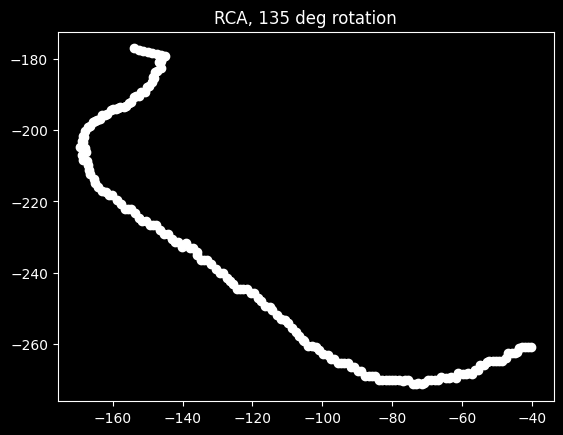

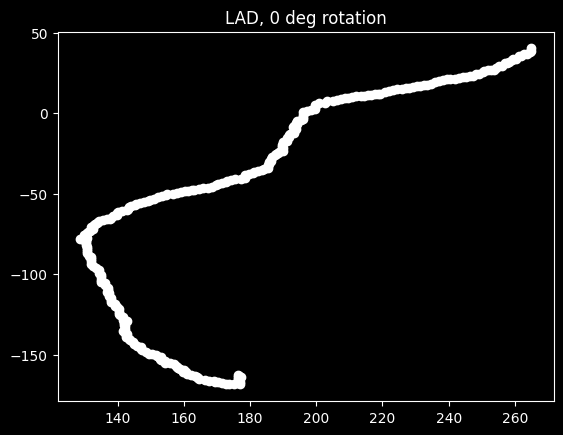

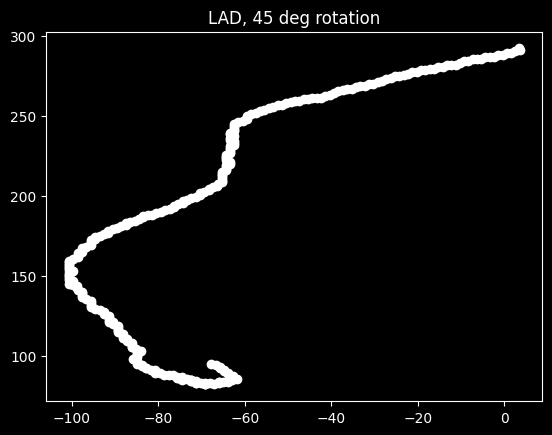

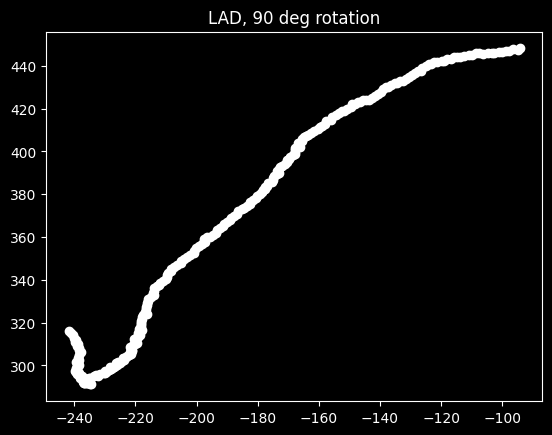

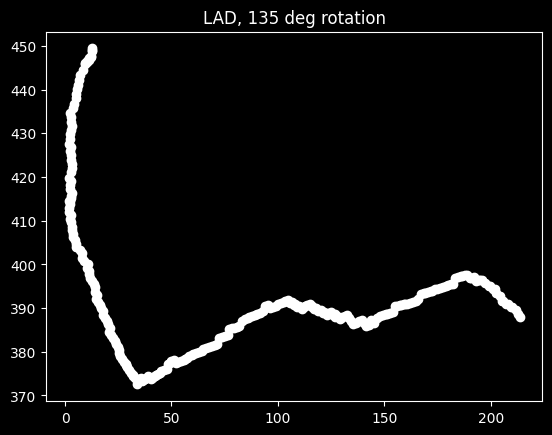

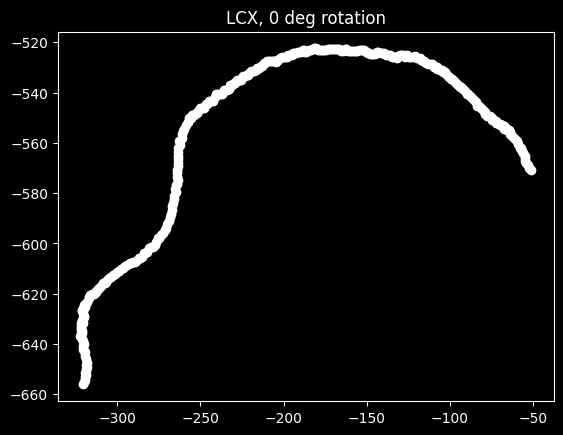

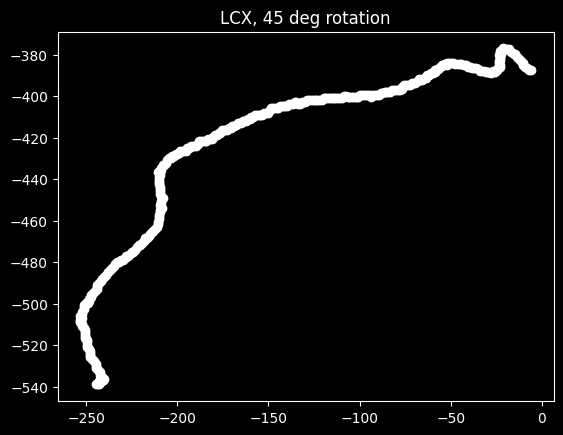

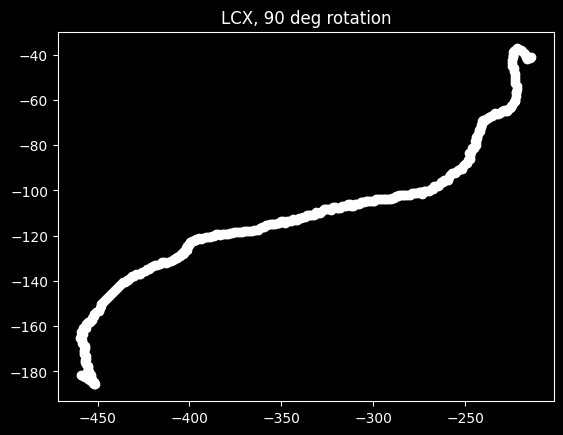

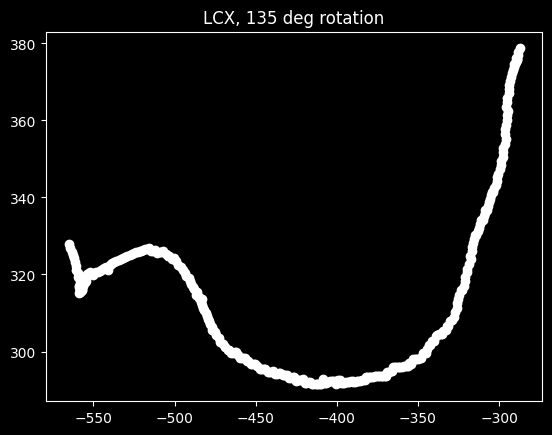

In [27]:
# testing a simpler MPR

def fit_plane_first_last(skeleton: np.ndarray):
    middle_point = skeleton[len(skeleton)//2]
    first_point = skeleton[0]
    last_point = skeleton[-1]
    
    vector1 = first_point - middle_point
    vector2 = last_point - middle_point
    normal = np.cross(vector1, vector2)
    return normal / np.linalg.norm(normal)

def project_vector(n: np.ndarray, v: np.ndarray):
    projected = v - (np.dot(v, n) / np.dot(n, n) * n)
    return projected / np.linalg.norm(projected)

def get_flow_vector(skeleton: np.ndarray):
    middle_point_id = len(skeleton)//2
    flow_vector = skeleton[middle_point_id+1] - skeleton[middle_point_id-1]
    return flow_vector / np.linalg.norm(flow_vector)

def project_point(plane: np.ndarray, point: np.ndarray):
    return point - np.dot(point, plane) * plane

def rotate_vector(f: np.ndarray, n: np.ndarray, degrees: float):
    rad_angle = np.radians(degrees)
    
    add1 = n * np.cos(rad_angle)
    add2 = np.cross(f, n) * np.sin(rad_angle)
    add3 = np.dot(f, n) * (1 - np.cos(rad_angle)) * f
    return add1 + add2 + add3

def map_3d_points_to_2d(normal, point_on_plane, points):
    # GPT GENERATED
    """
    Map 3D points lying on a plane to 2D coordinates.
    
    Args:
        normal (np.ndarray): Normal vector of the plane (3D).
        point_on_plane (np.ndarray): A reference point on the plane (3D).
        points (np.ndarray): Array of 3D points lying on the plane.

    Returns:
        np.ndarray: Array of 2D points in the plane's coordinate system.
    """
    # Normalize the normal vector
    normal = normal / np.linalg.norm(normal)
    
    # Find an arbitrary vector not parallel to the normal
    arbitrary = np.array([1, 0, 0]) if not np.allclose(normal, [1, 0, 0]) else np.array([0, 1, 0])
    
    # Compute the first basis vector (u)
    u = arbitrary - np.dot(arbitrary, normal) * normal
    u = u / np.linalg.norm(u)
    
    # Compute the second basis vector (v)
    v = np.cross(normal, u)
    v = v / np.linalg.norm(v)
    
    # Translate points relative to the reference point
    relative_points = points - point_on_plane
    
    # Compute 2D coordinates using dot products with the basis vectors
    points_2d = np.array([[np.dot(p, u), np.dot(p, v)] for p in relative_points])
    
    return points_2d



rotations = 4
rotation_degrees = 45

for branch in branches:
    points = [i.coordinates for i in branch.points]
    middle_point = points[len(points)//2]
    points = points - middle_point

    plane_normal = fit_plane_first_last(points)
    flow_vector = project_vector(plane_normal, get_flow_vector(points))
    
    
    # print(list([tuple(p) for p in points]))
    # print(projected_points)
    
    for i in range(rotations):
        rotated_plane = rotate_vector(flow_vector, plane_normal, i*rotation_degrees)
        projected_points = [tuple(project_point(rotated_plane, p)) for p in points]
        new_points = map_3d_points_to_2d(rotated_plane, middle_point, projected_points)
        plt.style.use('dark_background')
        plt.scatter(*zip(*new_points), c='w')
        plt.title(f'{branch.name}, {i*rotation_degrees} deg rotation')
        plt.show()
    
    

In [ ]:
def get_value(image: np.ndarray, coords: np.ndarray):
    x_size, y_size, z_size = image.shape
    coords = np.clip(coords, [0, 0, 0], [x_size-1, y_size-1, z_size-1])
    result = image[coords[:, 0], coords[:, 1], coords[:, 2]]
    return result

def mpr(image: np.ndarray, skeleton: Skeleton, rotations: int, x_step: int, y_step: int):
    middle_point: Point = copy.deepcopy(skeleton[len(skeleton)//2])
    main_skeleton = copy.deepcopy(skeleton).interpolate(step=x_step)
    
    rotation_degrees = 360 // rotations
    for _ in range(rotations):
        
        skeleton = copy.deepcopy(main_skeleton)
        new_image = np.zeros((len(np.arange(-200, 201, y_step)), len(skeleton)))
        middle_point.rotate_normal(np.pi/180*rotation_degrees)
        coord_offset = middle_point.coordinates.copy()
        normal = middle_point.normal
        
        #1) calculate all the points coords relative to the middle point
        for point in skeleton:
            point.coordinates -= coord_offset
        
        #2) project all points to the normal line - this will be the x direction of the point from the center in a 2D image
        n_dot_n = np.dot(normal, normal)
        for point in skeleton:
            # magnitude of projection of point p = np.dot(p, n)/np.dot(n, n)
            point.projection_magnitude = np.dot(point.coordinates, normal) / n_dot_n
        
        #3) for the y direction - place the normal vector on each other point and calculate the values of the line
        for i, point in enumerate(skeleton):
            steps = np.arange(-200, 201, y_step).astype(float) + point.projection_magnitude
            coords = (point.coordinates + coord_offset + steps[:, np.newaxis] * normal + 0.5).astype(int)
            values = get_value(image, coords).astype(int)
            new_image[:, i] = values
        
        fig, axes = plt.subplots(1, 1, figsize=(15, 5))
        new_image = cv.rotate(new_image, cv.ROTATE_90_CLOCKWISE)
        axes.imshow(new_image, cmap='gray')
        fig.suptitle(branch.name)
        plt.show()
    
for branch in [branches[2]]:
    mpr(base_image, branch, rotations=10, x_step = 0.1, y_step = 0.1)
    break

In [12]:
rotation_degrees = 45
number_of_rotations = 360 // rotation_degrees
for rot in range(number_of_rotations):
    branch.rotate_normals(rotation_degrees * rot * np.pi/180)

In [13]:
def display_branches(branches: list[Skeleton]) -> None:
    for branch in branches:
        branch_mask = np.zeros_like(image).astype(bool)
        for point in branch.points:
            branch_mask[tuple(point.coordinates)] = True
        create_ply(branch_mask, f'{branch.name}_branch.ply')
        
display_branches(branches)

100%|█████████████████████████████████████████████████████████| 340/340 [00:00<00:00, 169024.93it/s]


In [ ]:
def display_mpr(branch: Skeleton):
    mpr_test_x = np.zeros((image.shape[0], len(branch)))
    mpr_test_y = np.zeros((image.shape[1], len(branch)))
    mpr_test_z = np.zeros((image.shape[2], len(branch)))

    for i, p in enumerate(branch.points):
        coords = p.coordinates
        x_pixels = image[:, coords[1], coords[2]]
        y_pixels = image[coords[0], :, coords[2]]
        z_pixels = image[coords[0], coords[1], :]
        
        mpr_test_x[:, i] = x_pixels
        mpr_test_y[:, i] = y_pixels
        mpr_test_z[:, i] = z_pixels

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(mpr_test_x, cmap='gray')
    axes[1].imshow(mpr_test_y, cmap='gray')
    axes[2].imshow(mpr_test_z, cmap='gray')
    fig.suptitle(branch.name)
    plt.show()
    
for branch in branches:
    display_mpr(branch)

In [15]:
# create_ply(image, f'1.0_image.ply')
# create_ply(filtered_mask, f'1.1_filtered.ply')
# create_ply(eroded_mask, f'1.2_eroded.ply')
# create_ply(heartless_mask, f'1.3_heartless.ply')
create_ply(trimmed_mask, f'1.4_trimmed.ply')
create_ply(skeleton_mask, f'1.5_skeleton.ply')
create_ply(filtered_skeleton_mask, f'1.6_closest_skeletons.ply')

100%|█████████████████████████████████████████████████████████| 926/926 [00:00<00:00, 154344.52it/s]
